# Test spline fitting and Gaussian process regression 



## Setup

In [1]:
import os 
import gc
import re
import csv
import glob
import math
import umap
import json
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from tqdm import tqdm
from scipy import stats
from collections import * 
from sklearn import cluster
from sklearn import decomposition
from ete4 import NCBITaxa, Tree
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from scipy import stats, special
from numba import njit, prange, set_num_threads


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('/scratch/bgrodner/repo-armbrust-metat-search')

In [3]:
import functions.fn_metat_files as fnf
import functions.fn_correlation as fc
import functions.fn_regression_model as frm

In [4]:
ncbi = NCBITaxa()

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
os.getcwd()

'/scratch/bgrodner/iron_ko_contigs'

In [7]:
workdir = '/scratch/bgrodner/iron_ko_contigs'
os.chdir(workdir)


In [8]:
os.getcwd()

'/scratch/bgrodner/iron_ko_contigs'

In [9]:
os.listdir()

['config.yaml',
 'sc_run_snakemake.sh',
 'file_table.240210.kofam_filt.csv',
 '._.DS_Store',
 '._pfams_lauren_manck.xlsx',
 'file_table.240107.kofam_filt.csv',
 'sacha_hmm_search_results',
 'apptainer_home',
 'file_table.240109.kofam_filt.csv',
 'file_table_new.csv',
 '._file_table.240109.kofam_filt.csv',
 'file_table.test.csv',
 'jupyter_home',
 '._file_table.240210.kofam_filt.csv',
 '._file_table.240107.kofam_filt.csv',
 'ko00001.json',
 'error.txt',
 '._file_table_new.csv',
 'file_table.240114.kofam_filt.csv',
 'metat_search_results',
 'sidero_receptors',
 'pfams_lauren_manck.xlsx',
 '._file_table.csv',
 'file_table.240113.kofam_filt.csv',
 'file_table.240107.kofam_unfilt.csv',
 'nb_isolate_genes.ipynb',
 'tidytest.csv',
 '._file_table.240108.kofam_filt.csv',
 'kofam_filenames.txt',
 '.etetoolkit',
 'iron_contigs.txt',
 '.DS_Store',
 'iron_KOs.txt',
 'file_table.240108.kofam_filt.csv',
 'file_table.csv',
 '._file_table.240107.kofam_unfilt.csv',
 '._plt_KO_contig_counts.png',
 '._fil

Plotting

In [10]:
def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)

def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o',
    cmap_name='tab20',
    cl_lab=False
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle,
            cmap=cmap_name
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)


def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o'
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


def get_colors_from_stringlist(stringlist, order="", cmap_name="viridis"):
    if not order:
        order = list(set(stringlist))
    n_strings = len(order)
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / n_strings) for i in range(n_strings)]
    dict_str_col = {s: c for s, c in zip(order, colors)}
    return [dict_str_col[s] for s in stringlist], dict_str_col


def plot_legend(color_dict, figsize=(2, 4)):
    fig, ax = general_plot(dims=figsize)
    # Create legend handles manually
    legend_handles = []
    for value, color in color_dict.items():
        patch = mpatches.Patch(color=color, label=value)
        legend_handles.append(patch)

    # Add legend to the plot
    ax.legend(handles=legend_handles)
    return fig, ax


def taxon_legend(
    taxon_names,
    taxon_colors,
    label_color="k",
    taxon_counts=[],
    text_shift_vh=(6, 0.15),
    ft=20,
    dims=(6, 10),
    lw=2,
    ylabel="Genus",
):
    fig, ax = general_plot(ylabel=ylabel, dims=dims, col=label_color, lw=lw, ft=ft)
    vals = np.repeat(10, len(taxon_names))
    y_pos = np.arange(len(taxon_names))
    ax.barh(y_pos, vals, align="center", color=taxon_colors)
    if len(taxon_counts) > 0:
        # Label the legend with counts
        for i, (v, c) in enumerate(zip(vals, taxon_counts)):
            ax.text(
                v - text_shift_vh[0],
                i + text_shift_vh[1],
                str(c),
                color="k",
                fontsize=ft,
            )
    # Remove the boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add the genus names to the y axis
    ax.set_yticks(y_pos)
    ax.set_xticks([])
    ax.set_yticklabels(taxon_names)
    ax.invert_yaxis()
    return (fig, ax)


def marker_legend(
    names,
    markers,
    label_color="k",
    text_shift_hv=(0.5, 0),
    markersize=50,
    ft=20,
    dims=(3, 3),
    lw=2,
    ylabel="Genus",
):
    fig, ax = general_plot(ylabel=ylabel, dims=dims, col=label_color, lw=lw, ft=ft)
    for i, (n, m) in enumerate(zip(names, markers)):
        ax.scatter(0, i, marker=m, c=label_color, s=markersize)
        # ax.text(
        #     0 - text_shift_hv[0],
        #     i + text_shift_hv[1],
        #     str(n),
        #     color=label_color,
        #     fontsize=ft,
        #     va="center",
        # )
    # Remove the boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add the genus names to the y axis

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, i + 1])

    ax.set_yticks(np.arange(i+1))
    ax.set_xticks([])
    ax.set_yticklabels(names)
    ax.invert_yaxis()
    ax.invert_yaxis()
    return fig, ax

#### Get KO dict

Get dataframe

In [13]:
ko_fn = "ko00001.json"
database = list()
for _, v in pd.read_json(ko_fn).iterrows():
    d = v["children"]
    cat_1 = d["name"]
    for child_1 in d["children"]:
        cat_2 = child_1["name"] # Module?
        for child_2 in child_1["children"]:
            cat_3 = child_2["name"]
            if "children" in child_2:
                for child_3 in child_2["children"]:
                    cat_4 = child_3["name"]
                    fields = [cat_1, cat_2, cat_3, cat_4]
                    database.append(fields)
df_kegg = pd.DataFrame(database, columns=["Level_A", "Level_B", "Level_C", "Level_D"])
df_kegg.shape


(61993, 4)

In [14]:
ld = df_kegg['Level_D'].values
ld[:5]

array(['K00844  HK; hexokinase [EC:2.7.1.1]',
       'K12407  GCK; glucokinase [EC:2.7.1.2]',
       'K00845  glk; glucokinase [EC:2.7.1.2]',
       'K25026  glk; glucokinase [EC:2.7.1.2]',
       'K01810  GPI, pgi; glucose-6-phosphate isomerase [EC:5.3.1.9]'],
      dtype=object)

In [15]:
dict_ko_name = {}
for name in ld:
    ko = re.search(r"^\w+",name)[0]
    dict_ko_name[ko] = name

Get metadata table

In [16]:
metadata_path = "/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-metadata.csv"  # input('Enter the filepath of your batch metadata file:')
metadata = pd.read_csv(metadata_path)
metadata.iloc[[1,100,200],:]

,assembly,sample,latitude,ammendment,timepoint,depth,size,rep,fn_sample_counts,assm_sample,norm_factor
1,D1PA,S15C1,NaN,NaN,200,NaN,NaN,C,D1PA.S15C1_C_200.abundance.tsv,D1PA-S15C1-200,1970.000000
100,G1NS,S11C1,36.57deg,NaN,4_29_16-6:34,15.0m,0.2um,B,G1NS.S11C1_0_2um.B.tsv,G1NS-S11C1-36.57deg-4_29_16-6:34-15.0m-0.2um,3654.720049
200,G2PA,S06C1,39.76deg,NaN,NaN,15.0m,0.2um,B,G2PA.G2PA.S06C1.15m.0_2um.B.abundance.tsv,G2PA-S06C1-39.76deg-15.0m-0.2um,7091.826806


Correct G1 S11C1 latitudes

In [17]:
metadata.shape

(531, 11)

In [18]:
lats_new = []
for i, row in metadata.iterrows():
    if (row['sample'] == 'S11C1') & ('G1' in row['assembly']):
        lats_new.append('36.569deg')
    else:
        lats_new.append(row.latitude)
metadata['latitude'] = lats_new
metadata.iloc[[1,100,200,300,500],:]

,assembly,sample,latitude,ammendment,timepoint,depth,size,rep,fn_sample_counts,assm_sample,norm_factor
1,D1PA,S15C1,NaN,NaN,200,NaN,NaN,C,D1PA.S15C1_C_200.abundance.tsv,D1PA-S15C1-200,1970.000000
100,G1NS,S11C1,36.569deg,NaN,4_29_16-6:34,15.0m,0.2um,B,G1NS.S11C1_0_2um.B.tsv,G1NS-S11C1-36.57deg-4_29_16-6:34-15.0m-0.2um,3654.720049
200,G2PA,S06C1,39.76deg,NaN,NaN,15.0m,0.2um,B,G2PA.G2PA.S06C1.15m.0_2um.B.abundance.tsv,G2PA-S06C1-39.76deg-15.0m-0.2um,7091.826806
300,G3PA,UW37,37.0deg,NaN,4_19_19-18:47,7.0m,3.0um,C,G3PA.UW47.unstranded.abundance.tsv.gz,G3PA-UW37-37.0deg-4_19_19-18:47-7.0m-3.0um,1642.973173
500,G5,Mix1,NaN,DON,T2,NaN,NaN,C,G5.Mix1.DON.T2.C.tsv,G5-Mix1-DON-T2,4262.243999


Get cruise column

In [19]:
metadata.assembly.unique()

array(['D1PA', 'G1PA', 'G1NS', 'G2PA', 'G2NS', 'G3PA', 'G3PA.diel',
       'G3.UW.NS', 'G3PA.PM', 'G5'], dtype=object)

In [20]:
skp = ['D1PA','G3PA.diel','G3PA.PM','G5']
metadata['cruise'] = [assm[:2] if assm not in skp else assm for assm in metadata.assembly]
sels = []
for assm in metadata.assembly:
    if 'NS' in assm:
        sels.append('NS')
    elif assm == 'G5':
        sels.append('NS')
    else:
        sels.append('PA')

metadata['selection'] = sels
metadata.cruise.unique(), metadata.selection.unique()

(array(['D1PA', 'G1', 'G2', 'G3', 'G3PA.diel', 'G3PA.PM', 'G5'],
       dtype=object),
 array(['PA', 'NS'], dtype=object))

Batch column

In [21]:
batchs = []
for i, row in metadata.iterrows():
    cruise, sel, size = [row[v] for v in ['cruise','selection','size']]
    batchs.append(f'{cruise}_{sel}_{size}')

metadata['batch'] = batchs

Map fnsamplecounts to metadata

In [22]:
dict_meta = {}
for i, row in metadata.iterrows():
    dict_meta[row['fn_sample_counts']] = row.to_dict()

In [23]:
dict_assam_meta = {}
for i, row in metadata.iterrows():
    dict_assam_meta[row['assm_sample']] = row.to_dict()

In [24]:
dict_batch_meta = {}
for i, row in metadata.iterrows():
    dict_batch_meta[row['batch']] = row.to_dict()

In [25]:
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))


TZCF info

In [26]:
dict_cruise_trans_sal_chl = {
    'G1': [32.15, 33.0],
    'G2': [32.5, 36.2],
    'G3': [32.34, 35],
}

## Load Data

Load iron ko dict

In [27]:
fn_tidy_ironko = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-tidy_all.csv'

# open read 
dict_iron_taxon_ko_sample_estcounts = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(float)
    )
)
with open(fn_tidy_ironko, 'r') as fr:
    row = next(fr)
    for row in fr:
        contig, sample, ko, tax, estcounts = row.split(",")
        dict_iron_taxon_ko_sample_estcounts[tax][ko][sample] += float(estcounts)

Load taxa groups of spatial profiles

In [28]:
fn_out = '/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm/dict_sel_sz_profiletype_taxa.json'
with open(fn_out, 'r') as f:
    dict_sel_sz_ptype_taxa = json.load(f)

In [29]:
dict_sel_sz_tax_ptype = defaultdict(lambda: defaultdict(dict))
for sel, dict_sz_ptype_taxa in dict_sel_sz_ptype_taxa.items():
    for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
        for ptype, taxa in dict_ptype_taxa.items():
            for tax in taxa:
                dict_sel_sz_tax_ptype[sel][sz][tax] = ptype

Load taxon estcounts dict

In [30]:
fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

dict_sel_sz_tax_sample_estcounts = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
# for i, row in df_norm_abund.iterrows():
#     dict_tax_sam_ectotal[row.taxid][row.assm_sample][row.rep] = row.estcounts
    
valtypes = ['frac','trl']
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        row_meta = dict_meta[sam]
        cruise = row_meta['cruise']
        if cruise in ['G1','G2','G3']:
            lat, sel, size, norm_factor, rep = [row_meta[v] for v in ['latitude','selection','size','norm_factor', 'rep']]
            dict_sel_sz_tax_sample_estcounts[sel][size][taxid][sam] = float(estcounts)



Get a frac and trl for taxa

In [31]:
fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

dict_valtype_sel_sz_tax_sam_val = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(dict)
        )
    )
)

# for i, row in df_norm_abund.iterrows():
#     dict_tax_sam_ectotal[row.taxid][row.assm_sample][row.rep] = row.estcounts
    
# valtypes = ['frac','trl']
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        row_meta = dict_meta[sam]
        cruise = row_meta['cruise']
        # if cruise == 'G3PA.diel':
        #     date, time = row_meta['timepoint'].split('-')
        #     time = time.zfill(5)
        #     pred = f'{date}-{time}'
        # elif cruise == 'D1PA':
        #     sample = row_meta['sample']
        #     timepoint = row_meta['timepoint']
        #     pred = f'{sample}-{timepoint}'
        # elif cruise == 'G5':
        #     sample = row_meta['sample']
        #     ammend = row_meta['ammendment']
        #     pred = 
        valtypes = ['frac','trl']
        if cruise in ['G1','G2','G3']:
            lat, sel, size, norm_factor, rep = [row_meta[v] for v in ['latitude','selection','size','norm_factor', 'rep']]
            frac = float(frac_total_estcounts)
            trl = float(estcounts) * float(norm_factor)
            for vt, val in zip(valtypes, [frac, trl]):
                dict_valtype_sel_sz_tax_sam_val[vt][sel][size][taxid][sam] = val



Load total counts

In [32]:
dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/count_sums'
dirs_counts = glob.glob(f'{dir_counts}/*')
dict_sn_totalcount = {}
for d in dirs_counts:
    fns = glob.glob(f'{d}/*')
    for fn in fns:
        with open(fn, 'r') as f:
            count = float(next(f))
        sn = os.path.split(fn)[1]
        sn = sn.split('-count')[0]
        if 'PA' in sn:
            sn = sn.split('gz.')[1]
        dict_sn_totalcount[sn] = count


## Get example curve

Define taxa of interest

In [35]:
target_taxnames = [
    'Alphaproteobacteria','Betaproteobacteria','Gammaproteobacteria',
    'Myxococcota','FCB group','PVC group',
    'Actinomycetota',
    'Bacillota','Cyanobacteriota',
    'Haptophyta','Streptophyta','Chlorophyta','Opisthokonta','Alveolata','Rhizaria',
    'Stramenopiles','Amoebozoa','Cryptophyceae','Discoba','Rhodophyta',
]
dict_taxname_tax = ncbi.get_name_translator(target_taxnames)
target_taxa = [dict_taxname_tax[n][0] for n in target_taxnames]
dict_tax_name = ncbi.get_taxid_translator(target_taxa)


Get list of subtaxa for each ptype

In [36]:
dict_targettax_sel_sz_ptype_taxa = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(list)
        )
    )
)
for sel, dict_sz_ptype_taxa in dict_sel_sz_ptype_taxa.items():
    for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
        for ptype, taxa in dict_ptype_taxa.items():
            for tax in taxa:
                try:
                    lin = ncbi.get_lineage(tax)
                    for tt in target_taxa:
                        if tt in lin:
                            dict_targettax_sel_sz_ptype_taxa[tt][sel][sz][ptype].append(tax)
                except:
                    pass

/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1457154 was translated into 2954382
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1453999 was translated into 2954383
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1317118 was translated into 1379903
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 876044 was translated into 2518989
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1267535 was translated into 639034
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 319236 was translated into 323273
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1217710

In [37]:
dict_sel_sz_ptype_tax_targettax = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
for tt, dict_sel_sz_ptype_taxa in dict_targettax_sel_sz_ptype_taxa.items():
    for sel, dict_sz_ptype_taxa in dict_sel_sz_ptype_taxa.items():
        for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
            for ptype, taxa in dict_ptype_taxa.items():
                for tax in taxa:
                    dict_sel_sz_ptype_tax_targettax[sel][sz][ptype][tax] = tt

Get total estcounts for taxa in each ptype

In [38]:
dict_targettax_sel_sz_ptype_sam_estcounts = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(float)
            )
        )
    )
)
for tt, d_sel_sz_ptype_taxa in dict_targettax_sel_sz_ptype_taxa.items():
    for sel, dict_sz_ptype_taxa in d_sel_sz_ptype_taxa.items():
        for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
            for ptype, taxa in dict_ptype_taxa.items():
                for tax in taxa:
                    for sample, estcounts in dict_sel_sz_tax_sample_estcounts[sel][sz][tax].items():
                        dict_targettax_sel_sz_ptype_sam_estcounts[tt][sel][sz][ptype][sample] += estcounts


Get gene ec counts within each group

In [39]:
dict_targettax_sel_sz_ptype_ko_sam_ec = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(
                    lambda: defaultdict(float)
                )
            )
        )
    )
)

for tt, d_sel_sz_ptype_taxa in dict_targettax_sel_sz_ptype_taxa.items():
    for sel, dict_sz_ptype_taxa in d_sel_sz_ptype_taxa.items():
        for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
            for ptype, taxa in dict_ptype_taxa.items():
                # Get total conts for ptype
                dict_sam_ptypecounts = dict_targettax_sel_sz_ptype_sam_estcounts[tt][sel][sz][ptype]
                # Sum the ec counts for the group of taxa for each sample for each ko
                dict_ko_sam_ecptype = defaultdict(lambda: defaultdict(float))
                for tax in taxa:
                    for sam, _ in dict_sam_ptypecounts.items():
                        for ko, dict_sam_kocounts in dict_iron_taxon_ko_sample_estcounts[tax].items():
                            dict_targettax_sel_sz_ptype_ko_sam_ec[tt][sel][sz][ptype][ko][sam] += (
                                dict_sam_kocounts[sam]  
                            )


Get the fractional abundance for each gene

In [40]:
dict_targettax_sel_sz_ptype_ko_sam_frac = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(dict)
            )
        )
    )
)
for tt, d_sel_sz_ptype_ko_sam_ec in dict_targettax_sel_sz_ptype_ko_sam_ec.items():
    for sel, d_sz_ptype_ko_sam_ec in d_sel_sz_ptype_ko_sam_ec.items():
        for sz, d_ptype_ko_sam_ec in d_sz_ptype_ko_sam_ec.items():
            for ptype, d_ko_sam_ec in d_ptype_ko_sam_ec.items():
                # Get total counts for ptype
                dict_sam_ptypecounts = dict_targettax_sel_sz_ptype_sam_estcounts[tt][sel][sz][ptype]
                for ko, d_sam_ec in d_ko_sam_ec.items():
                    for sam, ec in d_sam_ec.items():
                        ptypecounts = dict_sam_ptypecounts.get(sam, 0)
                        if ptypecounts > 0:
                            dict_targettax_sel_sz_ptype_ko_sam_frac[tt][sel][sz][ptype][ko][sam] = ec / ptypecounts
                        else:
                            dict_targettax_sel_sz_ptype_ko_sam_frac[tt][sel][sz][ptype][ko][sam] = np.nan


Build prediction dataframe for each group

In [41]:
dict_targetax_sel_sz_ptype_preddf = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
for tt, d_sel_sz_ptype_ko_sam_frac in dict_targettax_sel_sz_ptype_ko_sam_frac.items():
    for sel, dict_sz_ptype_ko_sam_frac in d_sel_sz_ptype_ko_sam_frac.items():
        for sz, dict_ptype_ko_sam_frac in dict_sz_ptype_ko_sam_frac.items():
            for ptype, dict_ko_sam_frac in dict_ptype_ko_sam_frac.items():
                df = pd.DataFrame(dict_ko_sam_frac)
                cruises = []
                lat_diffs = []
                for sam in df.index:
                    row_meta = dict_meta[sam]
                    lat, cruise = [row_meta[v] for v in ['latitude','cruise']]
                    lat = float(lat.strip('deg'))
                    _, tzcf = dict_cruise_trans_sal_chl[cruise]
                    lat_diff = lat - tzcf
                    cruises.append(cruise)
                    lat_diffs.append(lat_diff)
                df['cruise'] = cruises
                df['lat_diff'] = lat_diffs
                dict_targetax_sel_sz_ptype_preddf[tt][sel][sz][ptype] = df


Pick a gene and a target taxon

In [46]:
sel = 'PA'
sz = '0.2um'
ptype = 'frac_high_north_trl_high_north_'
tt = dict_taxname_tax['Chlorophyta'][0]
ko = 'K25287'
df = dict_targetax_sel_sz_ptype_preddf[tt][sel][sz][ptype]
dict_cruise_preddf = {}
for cruise in df['cruise'].unique():
    df_cruise = df[df['cruise'] == cruise]
    dict_cruise_preddf[cruise] = df_cruise[[ko,'lat_diff']]

### Quadratic effect of latitude

quadratic fit

In [56]:
dict_cruise_res = {}
for i, (cruise, df) in enumerate(dict_cruise_preddf.items()):
    dict_cruise_res[cruise] = frm.fit_many_models(
        data=df,
        response_cols=[ko],
        covariate_cols=['lat_diff'],
        poly_cols=['lat_diff'], 
        poly_degree=2,
        iqr_coefficient=10,
        perm_test_vars=['lat_diff'], 
        n_perm=1000, 
        stat='coef',
        random_state=None,
        n_jobs=1,
    )

chack
chack
chack


plot quadratic

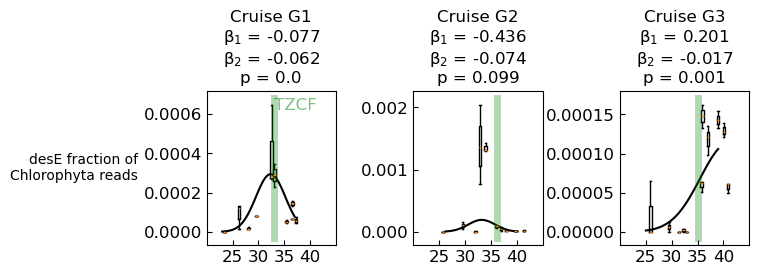

In [59]:
ft = 12
fig, axes = plt.subplots(1,3, figsize=(7,2))
for i, (cruise, df) in enumerate(dict_cruise_preddf.items()):
    _, tzcf = dict_cruise_trans_sal_chl[cruise]
    ax = axes[i]
    dict_lat_vals = defaultdict(list)
    for val, lat in df.values:
        dict_lat_vals[lat].append(val)
    vals = list(dict_lat_vals.values())
    pos = np.array(list(dict_lat_vals.keys())) + tzcf
    ax.boxplot(vals, positions=pos)
    
    dict_res = dict_cruise_res[cruise][ko]
    # Plot curves
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    crs = 0
    # if not cruise == 'G1':
    #     crs = dict_res['model'][f'GRADIENTS_{cruise}']
    x = np.linspace(-10,4,100)
    # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
    y = np.exp(const + ld*x + ld2*x**2 + crs)
    x_tzcf = x + tzcf
    ax.plot(x_tzcf, y, 'k')

    # Plot tzcf
    ylims = ax.get_ylim()
    ax.plot([tzcf]*2, ylims, 'g', alpha=0.3, lw=5)
    if i == 0:
        ax.text(tzcf, ylims[1], 'TZCF', color='g',alpha=0.5, fontsize=ft, va='top', ha='left')

    x = np.arange(25,45,5)
    ax.set_xticks(x)
    xticklabels = x
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(20,45)
    # ax.set_title(cruise, size=ft)
    ax.tick_params(axis='both',direction="in", labelsize=ft)

    p = dict_res['perm_pvalues']['p_value']['lr_stat']
    sscrpt = [1,2]
    text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
    # ax.yaxis.set_label_position("right")
    # ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')

    ax.set_title(f'Cruise {cruise}\n{text}')

    if i == 0:
        ax.set_ylabel('desE fraction of\nChlorophyta reads', rotation=0, va='center', ha='right')

plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Smoothing spline

fit spline

In [88]:
from scipy.interpolate import make_smoothing_spline

dict_cruise_spl = {}
for i, (cruise, df) in enumerate(dict_cruise_preddf.items()):
    dict_lat_vals = defaultdict(list)
    for val, lat in df.values:
        dict_lat_vals[lat].append(val)
    vals = list(dict_lat_vals.values())
    lats = list(dict_lat_vals.keys())
    y = [np.median(v) for v in vals]
    vrs = np.array([np.var(v) for v in vals])
    mnv = np.min(vrs[vrs > 0]) / 10
    vrs[vrs == 0] = mnv
    weights = -np.log(vrs)
    
    w = [x for _, x in sorted(zip(lats, weights))]
    x = np.array(sorted(lats)) + tzcf
    y = [x for _, x in sorted(zip(lats, y))]
    dict_cruise_spl[cruise] = make_smoothing_spline(x,y, w, lam=25)

plot quadratic

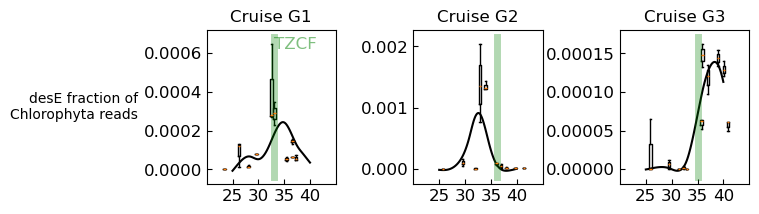

In [89]:
ft = 12
fig, axes = plt.subplots(1,3, figsize=(7,2))
for i, (cruise, df) in enumerate(dict_cruise_preddf.items()):
    _, tzcf = dict_cruise_trans_sal_chl[cruise]
    ax = axes[i]
    dict_lat_vals = defaultdict(list)
    for val, lat in df.values:
        dict_lat_vals[lat].append(val)
    vals = list(dict_lat_vals.values())
    pos = np.array(list(dict_lat_vals.keys())) + tzcf
    ax.boxplot(vals, positions=pos)
    
    spl = dict_cruise_spl[cruise]
    # Plot curves
    # const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    # crs = 0
    # if not cruise == 'G1':
    #     crs = dict_res['model'][f'GRADIENTS_{cruise}']
    x = np.linspace(25,40,100)
    # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
    y = spl(x)
    ax.plot(x, y, 'k')

    # Plot tzcf
    ylims = ax.get_ylim()
    ax.plot([tzcf]*2, ylims, 'g', alpha=0.3, lw=5)
    if i == 0:
        ax.text(tzcf, ylims[1], 'TZCF', color='g',alpha=0.5, fontsize=ft, va='top', ha='left')

    x = np.arange(25,45,5)
    ax.set_xticks(x)
    xticklabels = x
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(20,45)
    # ax.set_title(cruise, size=ft)
    ax.tick_params(axis='both',direction="in", labelsize=ft)

    # p = dict_res['perm_pvalues']['p_value']['lr_stat']
    # sscrpt = [1,2]
    # text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
    # ax.yaxis.set_label_position("right")
    # ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')

    ax.set_title(f'Cruise {cruise}')

    if i == 0:
        ax.set_ylabel('desE fraction of\nChlorophyta reads', rotation=0, va='center', ha='right')

plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Gaussian process regression

fit spline

In [102]:
np.ptp(y_train)

np.float64(0.00016274169974036612)

In [117]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RBF, ConstantKernel


dict_cruise_gpr = {}
for i, (cruise, df) in enumerate(dict_cruise_preddf.items()):
    _, tzcf = dict_cruise_trans_sal_chl[cruise]
    X_train = df[['lat_diff']].values + tzcf
    y_train = df[[ko]].values
    rngy = np.ptp(y_train)
    kernel = rngy * RBF(length_scale=10.0, length_scale_bounds='fixed')

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    gp.fit(X_train, y_train)
    dict_cruise_gpr[cruise] = gp

/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 2 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 3 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/conda/lib/python3.10

plot gaussian process regression

/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:481: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


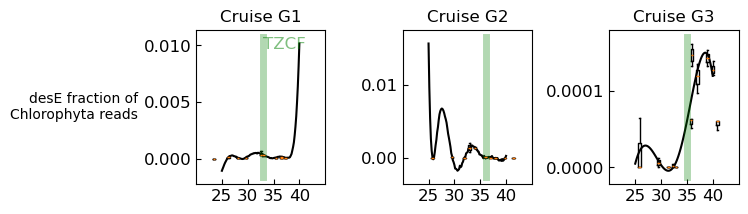

In [116]:
ft = 12
fig, axes = plt.subplots(1,3, figsize=(7,2))
for i, (cruise, df) in enumerate(dict_cruise_preddf.items()):
    _, tzcf = dict_cruise_trans_sal_chl[cruise]
    ax = axes[i]
    dict_lat_vals = defaultdict(list)
    for val, lat in df.values:
        dict_lat_vals[lat].append(val)
    vals = list(dict_lat_vals.values())
    pos = np.array(list(dict_lat_vals.keys())) + tzcf
    ax.boxplot(vals, positions=pos)
    
    gpr = dict_cruise_gpr[cruise]
    # Plot curves
    # const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    # crs = 0
    # if not cruise == 'G1':
    #     crs = dict_res['model'][f'GRADIENTS_{cruise}']
    x = np.linspace(25,40,100)
    # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
    y, sigma = gpr.predict(x[:,None], return_std=True)
    ax.plot(x, y, 'k')

    # Plot tzcf
    ylims = ax.get_ylim()
    ax.plot([tzcf]*2, ylims, 'g', alpha=0.3, lw=5)
    if i == 0:
        ax.text(tzcf, ylims[1], 'TZCF', color='g',alpha=0.5, fontsize=ft, va='top', ha='left')

    x = np.arange(25,45,5)
    ax.set_xticks(x)
    xticklabels = x
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(20,45)
    # ax.set_title(cruise, size=ft)
    ax.tick_params(axis='both',direction="in", labelsize=ft)

    # p = dict_res['perm_pvalues']['p_value']['lr_stat']
    # sscrpt = [1,2]
    # text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
    # ax.yaxis.set_label_position("right")
    # ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')

    ax.set_title(f'Cruise {cruise}')

    if i == 0:
        ax.set_ylabel('desE fraction of\nChlorophyta reads', rotation=0, va='center', ha='right')

plt.subplots_adjust(wspace=0.6, hspace=0.3)


In [109]:
y

array([ 3.99006140e-14,  2.39213972e-11,  4.23330862e-09,  2.21136150e-07,
        3.40977703e-06,  1.55195328e-05,  2.08505602e-05,  8.26881427e-06,
        9.67955007e-07,  3.34467196e-08,  3.41144450e-10,  1.02709240e-12,
        9.12782169e-16,  2.39447994e-19,  1.85413640e-23,  4.23797689e-28,
        2.85931440e-33,  5.69444848e-39,  1.37326870e-40,  8.56800672e-35,
        1.57797852e-29,  8.57844955e-25,  1.37658470e-20,  6.52053906e-17,
        9.11696918e-14,  3.76273729e-11,  4.58399074e-09,  1.64842803e-07,
        1.74977688e-06,  5.48253963e-06,  5.07069292e-06,  1.38432884e-06,
        1.11557210e-07,  2.65364272e-09,  1.86326093e-11,  3.86181379e-14,
        2.36262832e-17,  4.21218738e-21, -2.25278769e-20, -2.75121360e-18,
       -9.91768656e-17, -1.05527233e-15, -3.16010061e-15,  1.55075541e-13,
        4.77588163e-11,  4.25738724e-09,  1.12024121e-07,  8.70094357e-07,
        1.99483777e-06,  1.35000451e-06,  2.69678467e-07,  1.58840991e-08,
        2.27210264e-10, -